In [1]:
pip install python-binance

     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 288 kB 8.8 MB/s 
     |████████████████████████████████| 103 kB 36.7 MB/s 
     |████████████████████████████████| 1.1 MB 42.4 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 144 kB 49.8 MB/s 
     |████████████████████████████████| 94 kB 2.7 MB/s 
     |████████████████████████████████| 271 kB 41.1 MB/s 


In [2]:
pip install websocket_client

     |████████████████████████████████| 54 kB 1.7 MB/s 


In [3]:
from binance.client import Client
from binance.enums import *
import time, datetime
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import math
import numpy as np
from functools import reduce

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
import sklearn.metrics as metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# **data scraping**

**OHLC data:**
An OHLC chart is a type of bar chart that shows open, high, low, and closing prices for each period. 

In [4]:
SOCKET = "wss://stream.binance.com:9443/ws/btcusdt@kline_1m"
TRADE_SYMBOL = 'BTCUSDT'
TRADE_SYMBOL_HISTORY = 'BTCUSDT'
API_KEY = 'ziew'
API_SECRET = 'ziew'

In [5]:
client = Client(API_KEY, API_SECRET)#, tld='us')

In [6]:

def GetHistoricalData(howLong):
    howLong = howLong
    # Calculate the timestamps for the binance api function
    untilThisDate = datetime.now()
    # sinceThisDate = untilThisDate - datetime.timedelta(days = howLong)
    sinceThisDate = untilThisDate - timedelta(hours = howLong)
    # Execute the query from binance - timestamps must be converted to strings !
    candle = client.get_historical_klines(TRADE_SYMBOL_HISTORY, Client.KLINE_INTERVAL_1MINUTE, str(sinceThisDate), str(untilThisDate))
    # print("TYPE", type(candle),"\n",candle)

    # Create a dataframe to label all the columns returned by binance so we work with them later.
    df = pd.DataFrame(candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    # as timestamp is returned in ms, let us convert this back to proper timestamps.
    df.dateTime = pd.to_datetime(df.dateTime, unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
    # df.set_index('dateTime', inplace=True)

    df["open"] = df.open.astype(float)
    df["high"] = df.high.astype(float)
    df["low"] = df.low.astype(float)
    df["close"] = df.close.astype(float)
    df["volume"] = df.volume.astype(float)

    # Get rid of columns we do not need
    df = df.drop(['quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore','closeTime'], axis=1)

    return df

In [7]:
print("Launching script...")
df=GetHistoricalData(24*1100) # TAKE INTO ACCOUNT GMT-2 #1100 days

Launching script...


In [9]:
df.tail()

,dateTime,open,high,low,close,volume
1579986,2022-02-27 22:07:00,37535.15,37555.97,37512.20,37526.11,17.57807
1579987,2022-02-27 22:08:00,37526.10,37537.12,37510.37,37520.42,10.49549
1579988,2022-02-27 22:09:00,37520.42,37584.14,37520.41,37540.02,37.91936
1579989,2022-02-27 22:10:00,37540.02,37552.11,37487.40,37490.00,28.66044
1579990,2022-02-27 22:11:00,37490.01,37528.57,37456.91,37521.50,19.07429


In [10]:
df.shape

(1579991, 6)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579991 entries, 0 to 1579990
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   dateTime  1579991 non-null  object 
 1   open      1579991 non-null  float64
 2   high      1579991 non-null  float64
 3   low       1579991 non-null  float64
 4   close     1579991 non-null  float64
 5   volume    1579991 non-null  float64
dtypes: float64(5), object(1)
memory usage: 72.3+ MB


In [12]:
include =['float', 'int']
df.describe(include = include)

,open,high,low,close,volume
count,1.579991e+06,1.579991e+06,1.579991e+06,1.579991e+06,1.579991e+06
mean,2.382540e+04,2.384185e+04,2.380883e+04,2.382542e+04,4.269391e+01
std,1.908548e+04,1.909913e+04,1.907187e+04,1.908548e+04,6.530334e+01
min,3.674850e+03,3.679000e+03,3.670690e+03,3.674850e+03,0.000000e+00
25%,8.752410e+03,8.757300e+03,8.747540e+03,8.752320e+03,1.401756e+01
50%,1.136800e+04,1.137281e+04,1.136309e+04,1.136803e+04,2.526840e+01
75%,4.172229e+04,4.174805e+04,4.169958e+04,4.172228e+04,4.681302e+01
max,6.900000e+04,6.900000e+04,6.878670e+04,6.900000e+04,3.564139e+03


In [13]:
#covert datatime column from object dtype to datetime dtype
df["dateTime"] = df.dateTime.astype('datetime64[ns]')

In [14]:
df = df.rename({'close': 'price'}, axis='columns')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1579991 entries, 0 to 1579990
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   dateTime  1579991 non-null  datetime64[ns]
 1   open      1579991 non-null  float64       
 2   high      1579991 non-null  float64       
 3   low       1579991 non-null  float64       
 4   price     1579991 non-null  float64       
 5   volume    1579991 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 72.3 MB


In [16]:
#Set time column as Index
df.set_index('dateTime',inplace=True)

In [17]:
df.tail()

,open,high,low,price,volume
dateTime,,,,,
2022-02-27 22:07:00,37535.15,37555.97,37512.20,37526.11,17.57807
2022-02-27 22:08:00,37526.10,37537.12,37510.37,37520.42,10.49549
2022-02-27 22:09:00,37520.42,37584.14,37520.41,37540.02,37.91936
2022-02-27 22:10:00,37540.02,37552.11,37487.40,37490.00,28.66044
2022-02-27 22:11:00,37490.01,37528.57,37456.91,37521.50,19.07429


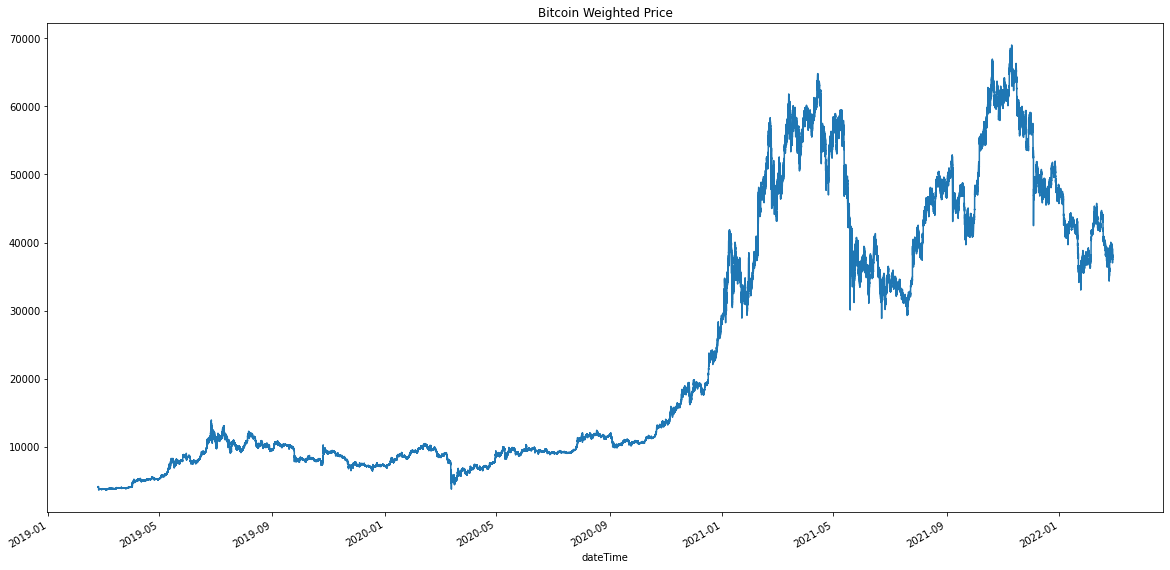

In [18]:
#plot
df['price'].plot(title = "Bitcoin Weighted Price",x = "time",y = "price",figsize=(20, 10))
plt.show()

## **Time series**

Text(0.5, 1.0, 'Weekly Lag')

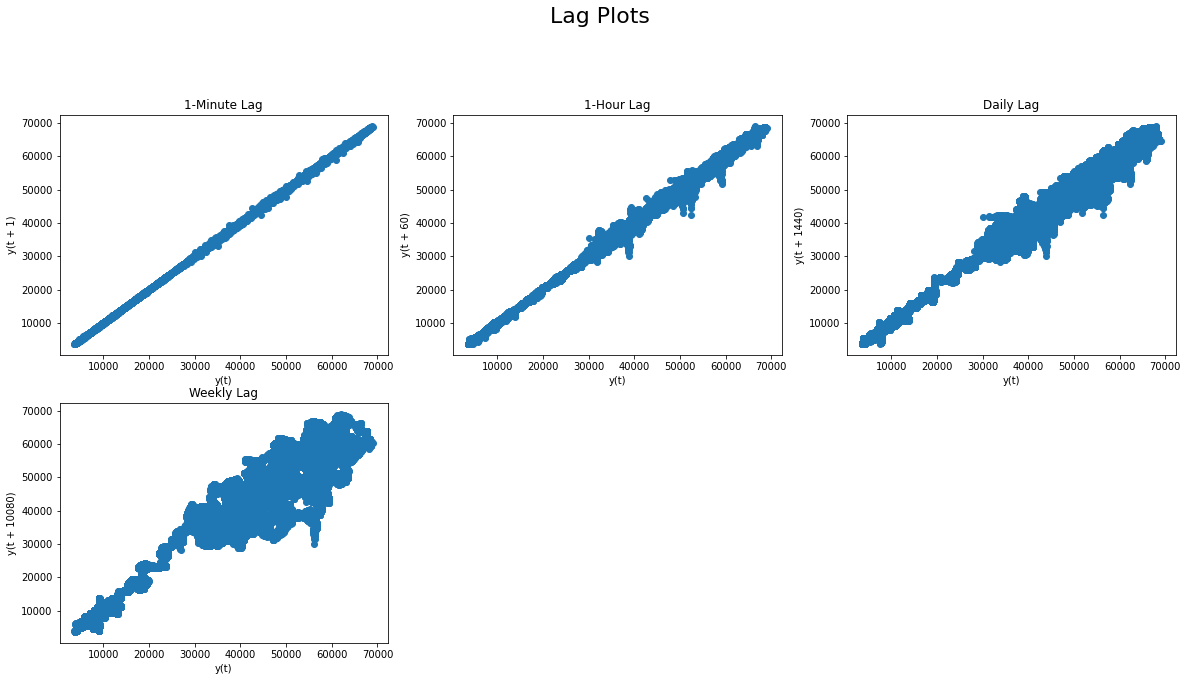

In [19]:
#Auto-correlation 
plt.figure(figsize=(20,15))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(df['price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(df['price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(df['price'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(df['price'], lag=10080) #weekly lag
plt.title('Weekly Lag')

In [20]:
df['date'] = pd.to_datetime(df.index,unit='H').date
display(df.head())
group = df.groupby('date')
new_df = group['price'].mean()
display(new_df.head())

,open,high,low,price,volume,date
dateTime,,,,,,
2019-02-23 22:12:00,4114.81,4116.34,4114.28,4115.02,25.329495,2019-02-23
2019-02-23 22:13:00,4116.00,4116.35,4115.01,4115.08,5.953686,2019-02-23
2019-02-23 22:14:00,4116.29,4118.90,4115.06,4116.60,23.756569,2019-02-23
2019-02-23 22:15:00,4117.49,4121.82,4116.62,4119.60,38.157370,2019-02-23
2019-02-23 22:16:00,4120.03,4123.13,4119.25,4123.13,7.569117,2019-02-23


date
2019-02-23    4118.302130
2019-02-24    3999.993771
2019-02-25    3810.477681
2019-02-26    3814.986535
2019-02-27    3809.681312
Name: price, dtype: float64

In [21]:
new_df.shape

(1101,)

## Data Split

In [22]:
# Train data = 950
# Test data =  151
#  Train data from 1 to Total data length - 151 days 
train = new_df[:950].values
# Test data : the last 151 days
test = new_df[950:].values

In [24]:
print(train.shape,test.shape)

(950,) (151,)


## Data Scaling

Standard Scaler for Data

we first need to split the data into training and test set before applying normalization over data.

we should perform feature normalisation over the training data. Then perform normalisation on testing instances as well, but this time using the mean and variance of training explanatory variables. In this way, we can test and evaluate whether our model can generalize well to new, unseen data points

In [25]:
train = train.reshape(-1,1)
test = test.reshape(-1,1)

In [26]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
#scaled_train  = scaler.fit_transform(train)

scaler = scaler.fit(train)
scaled_train = scaler.transform(train)

#scaler_test  = StandardScaler(copy=True, with_mean=True, with_std=True)
scaled_test   = scaler.transform(test)


In [27]:
scaled_train[0:50]

array([[-0.92323604],
       [-0.93027804],
       [-0.9415585 ],
       [-0.94129012],
       [-0.9416059 ],
       [-0.94064731],
       [-0.94019971],
       [-0.94110492],
       [-0.94113509],
       [-0.94595833],
       [-0.94341824],
       [-0.93921755],
       [-0.93762647],
       [-0.93665508],
       [-0.93552024],
       [-0.93550097],
       [-0.93714675],
       [-0.93731614],
       [-0.93791781],
       [-0.93792836],
       [-0.9358981 ],
       [-0.93052078],
       [-0.93137806],
       [-0.93101751],
       [-0.93053302],
       [-0.92957968],
       [-0.92947132],
       [-0.93091554],
       [-0.93046562],
       [-0.93090373],
       [-0.93200368],
       [-0.93430108],
       [-0.92983216],
       [-0.92887894],
       [-0.92596724],
       [-0.9246811 ],
       [-0.92427956],
       [-0.92222099],
       [-0.89403649],
       [-0.87134132],
       [-0.87382274],
       [-0.87277365],
       [-0.8692109 ],
       [-0.86345281],
       [-0.85926953],
       [-0

## Dataset Generator for LSTM

The input will be -> 1, 2, 3, 4, 5, 6, 7 

And the output will be -> 8 
-------
The input will be -> 2, 3, 4, 5, 6, 7, 8 

And the output will be -> 9
-------
...

In [28]:
def data_generator(data,lookback  = 7):
  x = [data[i:(i + lookback), 0] for i in range(len(data)-lookback)]
  y = [data[i+lookback, 0] for i in range(len(data)-lookback)]
  return np.array(x), np.array(y)

In [29]:
trainX, trainY = data_generator(scaled_train)
testX, testY = data_generator(scaled_test)

In [30]:
print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (943, 7)
trainY:  (943,)
testX:  (144, 7)
testY (144,)


Data Generator for Classification

In [31]:
def data_generator_clf(x,y):
  x = x[1:]
  y = [0 if y[i] > y[i+1] else 1 for i in range(len(y)-1)]
  return np.array(x), np.array(y)

In [32]:
trainX_clf, trainY_clf = data_generator_clf(trainX,trainY)
testX_clf, testY_clf = data_generator_clf(testX, testY)

In [33]:
print("trainX classification: ", trainX_clf.shape)
print("trainY classification: ", trainY_clf.shape)
print("testX classification: ", testX_clf.shape)
print("testY classification", testY_clf.shape)

trainX classification:  (942, 7)
trainY classification:  (942,)
testX classification:  (143, 7)
testY classification (143,)


In [34]:
trainY_clf[0:50]

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0])

For LSTM we need to reshape input to be a 3D Tensor of samples, time steps, features.

The number of time steps is equal to the number of LSTM cells

In [35]:
# We use the reshape() function on the NumPy array to reshape the one-dimensional array into a three-dimensional array.
def data_reshape(data):
  return np.reshape(data, (data.shape[0], data.shape[1], 1))

In [36]:
trainX = data_reshape(trainX)
testX = data_reshape(testX)

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (943, 7, 1)
Shape of testX:  (144, 7, 1)


In [37]:
trainX_clf = data_reshape(trainX_clf)
testX_clf = data_reshape(testX_clf)

print("Shape of trainX: ", trainX_clf.shape)
print("Shape of testX: ", testX_clf.shape)

Shape of trainX:  (942, 7, 1)
Shape of testX:  (143, 7, 1)


## LSTM Model

to convert an input sequence into an output sequence we use **return_sequences=True**.

In [38]:
# the input to every LSTM layer must be three-dimensional.
model = Sequential()
# input_shape is supposed to be (timesteps, n_features).
model.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))



# output layer
model.add(Dense(units = 1))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#checkpoint_path = 'my_best_model.hdf5'
'''
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
'''

earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ep = 100
BS = 8

callbacks = [earlystopping]
# callbacks = [checkpoint]


history = model.fit(trainX, trainY, batch_size = BS, epochs = ep, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/100
118/118 [==============================] - 11s 31ms/step - loss: 0.1344 - val_loss: 0.1138
Epoch 2/100
118/118 [==============================] - 3s 26ms/step - loss: 0.0681 - val_loss: 0.1028
Epoch 3/100
118/118 [==============================] - 3s 25ms/step - loss: 0.0445 - val_loss: 0.0768
Epoch 4/100
118/118 [==============================] - 3s 26ms/step - loss: 0.0378 - val_loss: 0.0473
Epoch 5/100
118/118 [==============================] - 3s 29ms/step - loss: 0.0332 - val_loss: 0.0327
Epoch 6/100
118/118 [==============================] - 3s 24ms/step - loss: 0.0282 - val_loss: 0.0390
Epoch 7/100
118/118 [==============================] - 3s 25ms/step - loss: 0.0343 - val_loss: 0.0416
Epoch 8/100
118/118 [==============================] - 3s 25ms/step - loss: 0.0326 - val_loss: 0.0350
Epoch 9/100
118/118 [==============================] - 3s 24ms/step - loss: 0.0327 - val_loss: 0.0421
Epoch 10/100
118/118 [==============================] - 3s 25ms/step - loss: 0.03

In [41]:
# Save the model
model.save_weights('LSTM_RNN_.h5')

In [42]:
# Load the model
model.load_weights('LSTM_RNN_.h5')

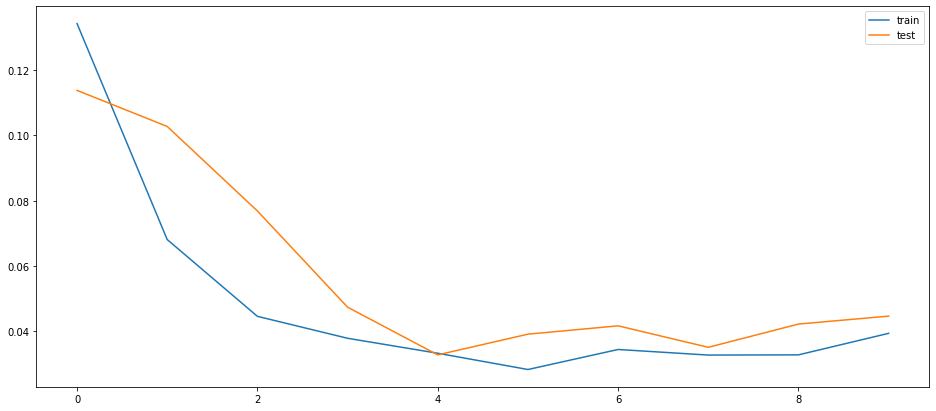

In [43]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

LSTM for classification

In [44]:

# Design Neural Network Architecture with LSTM
print('Building Simple RNN Model..')

model_clf = Sequential()
# input_shape is supposed to be (timesteps, n_features).
model_clf.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX_clf.shape[1], trainX_clf.shape[2])))
model_clf.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model_clf.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
model_clf.add(Dropout(0.2))

# Add Dense Hidden Layer

model_clf.add(Dense(256, activation='relu'))
model_clf.add(Dropout(0.3))
model_clf.add(Dense(128, activation='relu'))
model_clf.add(Dropout(0.3))

# Output Layer 
model_clf.add(Dense(1, activation='sigmoid'))

Building Simple RNN Model..


In [45]:
# Summary
model_clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 7, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [46]:
# Configure model
model_clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
# Train!
print('Training the model..')
history_clf = model_clf.fit(trainX_clf, trainY_clf, batch_size=BS, verbose=2, epochs=ep,shuffle=False, validation_data=(testX_clf, testY_clf), callbacks=callbacks)

Training the model..
Epoch 1/100
118/118 - 7s - loss: 0.6954 - accuracy: 0.5117 - val_loss: 0.6942 - val_accuracy: 0.4615 - 7s/epoch - 62ms/step
Epoch 2/100
118/118 - 3s - loss: 0.6936 - accuracy: 0.5287 - val_loss: 0.7020 - val_accuracy: 0.4615 - 3s/epoch - 22ms/step
Epoch 3/100
118/118 - 3s - loss: 0.6910 - accuracy: 0.5456 - val_loss: 0.7057 - val_accuracy: 0.4615 - 3s/epoch - 23ms/step
Epoch 4/100
118/118 - 3s - loss: 0.6905 - accuracy: 0.5467 - val_loss: 0.7072 - val_accuracy: 0.4615 - 3s/epoch - 23ms/step
Epoch 5/100
118/118 - 3s - loss: 0.6910 - accuracy: 0.5467 - val_loss: 0.7043 - val_accuracy: 0.4615 - 3s/epoch - 22ms/step
Epoch 6/100
118/118 - 3s - loss: 0.6910 - accuracy: 0.5435 - val_loss: 0.7065 - val_accuracy: 0.4615 - 3s/epoch - 22ms/step


In [48]:
# evaluate the classification model
_,acc = model_clf.evaluate(testX_clf, testY_clf)
print("acc: %.2f" % (acc))

5/5 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.4615
acc: 0.46


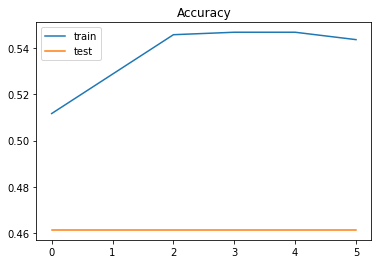

In [49]:
# Accuracy vs Epoch
plt.title('Accuracy')
plt.plot(history_clf.history['accuracy'], label='train')
plt.plot(history_clf.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## LSTM Predictions vs. Actual testY

We need to transfer the scale data to the original data (real value), So we are going to use **inverse_transform** to Scale back the data to the original representation.

In [50]:

predicted_test_data = model.predict(testX)
predicted_test_data = scaler.inverse_transform(predicted_test_data.reshape(-1, 1))
test_actual = scaler.inverse_transform(testY.reshape(-1, 1))

difference between Predictions and Actual

In [51]:
l = zip(predicted_test_data,test_actual)
m = map(lambda x: x[0]-x[1], l)
r = reduce(lambda x,y: x + y, m)
print("the number of days: 144")
print("result of Predictions - Actual testY:", r)

the number of days: 144
result of Predictions - Actual testY: [109309.10929748]


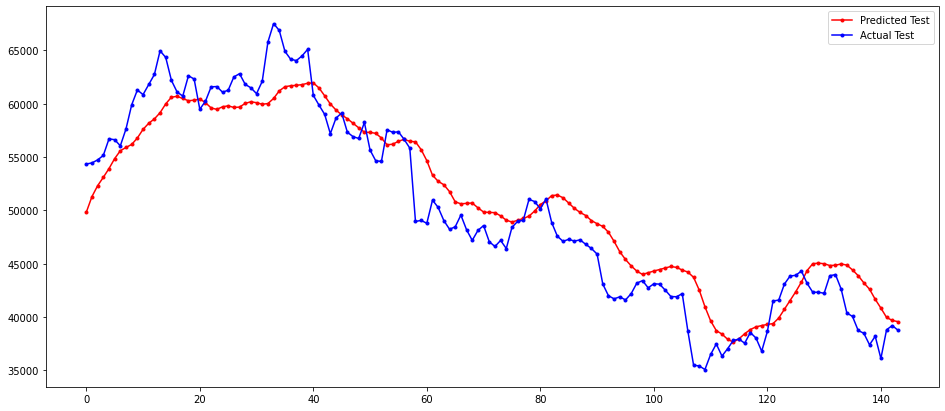

In [52]:
plt.figure(figsize=(16,7))

plt.plot(predicted_test_data, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, 'b', marker='.', label='Actual Test')

plt.legend()
plt.show()

##Mean squared error

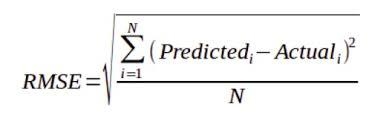

In [53]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model.predict(trainX)

predicted_btc_price_train_data = scaler.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler.inverse_transform(trainY.reshape(-1, 1))

In [54]:
# Train Data
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Test RMSE: %.3f' % rmse_lstm_train)

Test RMSE: 3054.857


In [55]:
# Test Data
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

Test RMSE: 3036.147


What if we invest X$ , how much money can we earn?

In [89]:
# what if we invest 5000 dollar during how much money can we earn after 143 days?
x = 5000
#intial_val = testX[0]
#intial_val = np.reshape(intial_val, (1, testX.shape[1], 1))
#print(intial_val.shape)
#print(intial_val)
#intial_val= model.predict(intial_val)[0]
intial_val = scaler.inverse_transform(testX[0].reshape(-1, 1))[0]


for i in range(testX.shape[0]-1):
  intial_val = scaler.inverse_transform(testX[i].reshape(-1, 1))[0]
  r = testX[i+1]
  r = np.reshape(r, (1, testX.shape[1], 1))
  r = model.predict(r)[0]
  r = scaler.inverse_transform(r.reshape(-1, 1))
  if intial_val >= r :
    pass
  else:
    real_val = scaler.inverse_transform(testX[i+1].reshape(-1, 1))[0]
    p = (real_val-intial_val)/intial_val
    x = x + (x*p)

print("According to this algo after 143 days , your money will get :",x)


According to this algo after 143 days , your money will get : [10517.27400128]



##Future Price Predictions

For 10 Days beyond the actual trading days for which I dont have the ground truth data (i.e. for 10-days into future for which I dont have actual Trading Price yet)
We are going to forecast the Bitcoin Prices for the next 10 days from today.


In [63]:
days = 10
lookback  = testX.shape[1]
print(lookback)

7


In [57]:
testX_last_n_days =testX[-1] #testX[testX.shape[0] - lookback :  ]
testX_last_n_days = np.reshape(testX_last_n_days, (1, testX.shape[1], 1))
print(testX_last_n_days.shape)
print(testX_last_n_days)
print(type(testX_last_n_days))

(1, 7, 1)
[[[1.13773052]
  [1.12214407]
  [1.05789394]
  [1.10551483]
  [0.98155307]
  [1.14183714]
  [1.16516094]]]
<class 'numpy.ndarray'>


In [58]:
# convert testX_last_n_days to queue
queue = testX_last_n_days
predicted_values = []
print(queue)

for i in range(days):
  
  predicted_value = model.predict(queue)[0]  #predicted_value = model.predict(testX_last_n_days)
  queue = queue.tolist()

  queue[0].pop(0)

  queue[0].append(predicted_value)

  predicted_value = scaler.inverse_transform(predicted_value.reshape(-1, 1))
  predicted_values.append(predicted_value)


  next_price = scaler.inverse_transform(queue[0][-1].reshape(-1, 1))
  last_price = scaler.inverse_transform(np.array(queue[0][-2]).reshape(-1, 1))
  if next_price > last_price:
    print("Buy crypto || +{s} ({p} %)".format(s = next_price - last_price, p = (next_price-last_price)/last_price))
  else:
    print("Sell crypto || - {s} ({p} %)".format(s = last_price - next_price, p = (next_price-last_price)/last_price))

  queue = np.asarray(queue).astype('float32')
 


[[[1.13773052]
  [1.12214407]
  [1.05789394]
  [1.10551483]
  [0.98155307]
  [1.14183714]
  [1.16516094]]]
Buy crypto || +[[367.59823958]] ([[0.0093765]] %)
Buy crypto || +[[355.79106813]] ([[0.00899103]] %)
Buy crypto || +[[247.05888409]] ([[0.00618768]] %)
Buy crypto || +[[423.16024745]] ([[0.01053302]] %)
Buy crypto || +[[377.36772846]] ([[0.00929528]] %)
Buy crypto || +[[696.78634531]] ([[0.01700509]] %)
Buy crypto || +[[431.07541865]] ([[0.0103445]] %)
Buy crypto || +[[451.45582281]] ([[0.01072265]] %)
Buy crypto || +[[457.0987424]] ([[0.0107415]] %)
Buy crypto || +[[455.65647071]] ([[0.01059381]] %)


In [59]:
print("Forecast for the next %2d Days Beyond the actual trading days "%  (days))
print(np.array(predicted_values))
print(np.array(predicted_values).shape)

Forecast for the next 10 Days Beyond the actual trading days 
[[[39571.785]]

 [[39927.574]]

 [[40174.633]]

 [[40597.793]]

 [[40975.16 ]]

 [[41671.945]]

 [[42103.02 ]]

 [[42554.477]]

 [[43011.574]]

 [[43467.23 ]]]
(10, 1, 1)


## Plot future Predictions (Future 10-days ) 

In [60]:
predicted = np.array(predicted_values).flatten()

In [61]:
predicted

array([39571.785, 39927.574, 40174.633, 40597.793, 40975.16 , 41671.945,
       42103.02 , 42554.477, 43011.574, 43467.23 ], dtype=float32)

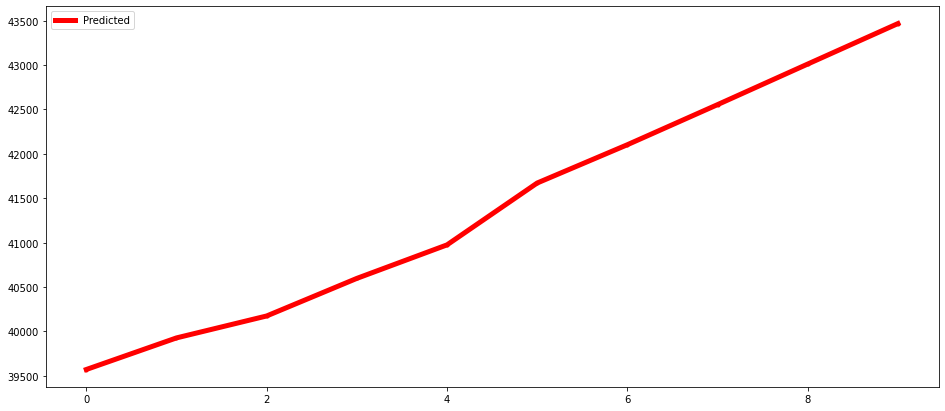

In [62]:
plt.figure(figsize=(16,7))

plt.plot(predicted, 'r', marker='.',lw=5, label='Predicted')

#plt.plot(yy, marker='.',lw=5, label='Actual')

plt.legend()

plt.show()